In [75]:
%matplotlib ipympl
from orbit_fitting import keplerian,rot_orbital_elements,kepler_III
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
from tqdm import tqdm
plt.style.use('dark_background')

In [76]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

### This notebook is for exploring orbital parameters that satisfy certain transiting coordinate and RV and acceleration requirements, visualising said parameter space.

In [77]:
import astropy.constants as const
import tayph.operations as ops
import pdb

au = const.au.value

N = 80 #This takes over 45 minutes.
a_range = np.geomspace(0.05,2.0,N) #AU
w_range = np.linspace(0.0,360.0,N)
W_range = np.radians(180) #deg
i_range = 0.0 #deg
e_range = np.linspace(0.1,0.99,N)
Mstar = 2.0
R_limit = 4.0*const.R_sun.value #solar radii.
r_limit = 1.0*au
#Wish to find combinations of a, w and e that match.


In [78]:
out = np.zeros((N,N,N))
out_s = []
for i in tqdm(range(N)):
    P = kepler_III(a_range[i]*const.au.value,Mstar*const.M_sun.value)
    n_steps = int(P/3600)*2*2 #We do 2 periods for each orbit, and we do 2 steps per hour. That's P/3600 times four.
    t = np.linspace(0,P/3600/24*2,n_steps)
    dt = (t[1]-t[0])#In days
    for j in range(N):
        for k in range(N):
            r,T,x,y,vx,vy = keplerian(t,a_au=a_range[i],e=e_range[j],M_Msun=Mstar)
            z,vz = x*0.0,vx*0.0
            x,y,z    = rot_orbital_elements(x,y,z,inc = i_range,omega=np.radians(w_range[k]),Omega=W_range)
            vx,vy,vz = rot_orbital_elements(vx,vy,vz,inc = i_range,omega=np.radians(w_range[k]),Omega=W_range)
            dvdt = ops.derivative(np.array(vy))/dt/24/1e3 #Acceleration in m/s per day *24/1e3 = km/s/h

            sel = (np.abs(x)<R_limit)&(y<0)&(r<r_limit)

            mrv,ma = np.mean(vy[sel]/1e3),np.mean(dvdt[sel])
            # print(i,j,k,mrv,ma)
            if mrv>-30 and mrv<-20 and ma>0.0: #< THIS HERE IS HARDCODED.
                out[i,j,k] = 1
                out_s.append([a_range[i],e_range[j],w_range[k]])


  0%|          | 0/80 [00:00<?, ?it/s]

 64%|██████▍   | 51/80 [15:19<14:23, 29.76s/it]/home/jens/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jens/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 80/80 [49:38<00:00, 37.23s/it] 


Text(0.5, 0, '$\\omega$ (deg)')

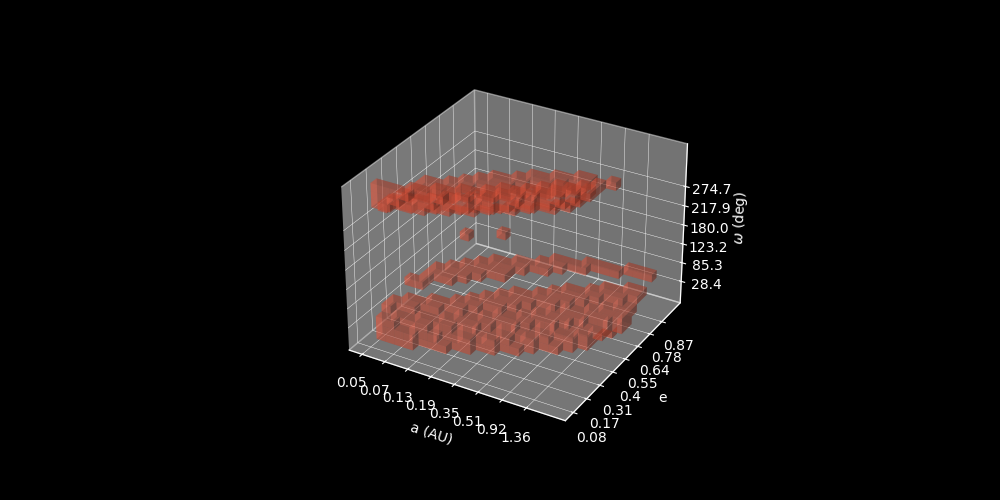

In [66]:
fig=plt.figure(figsize=(10,5))

ax0 = fig.add_subplot(1,1,1,projection='3d')

colors = np.empty(out.shape,dtype='object')
colors[out>0]='tomato'
ax0.voxels(out,facecolors='tomato',edgecolors=None,alpha=0.4);
ax0.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax0.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax0.zaxis._axinfo["grid"]['linewidth'] = 0.3


dy = e_range[1]-e_range[0]
dz = w_range[1]-w_range[0]
ax0.set_xticks(ax0.get_xticks()[1:-2],labels = np.round(a_range[ax0.get_xticks()[1:-2].astype(int)],2))
ax0.set_yticks(ax0.get_yticks()[1:-2],labels = np.round(e_range[ax0.get_yticks()[1:-2].astype(int)]-0.5*dy,2))
ax0.set_zticks(ax0.get_zticks()[1:-2],labels = np.round(w_range[ax0.get_zticks()[1:-2].astype(int)]-0.5*dz,1))

ax0.set_xlabel('a (AU)')
ax0.set_ylabel('e')
ax0.set_zlabel('$\omega$ (deg)')

# ax0.set_xlabel('a (AU)')
# ax0.set_ylabel('e')
# ax0.set_zlabel('w (deg)')
# # ax0.set_aspect('equal')



# for i in range(N):
    # for j in range(N):
        # ax0.plot(a_range,e_range,w_range[i],'.',alpha=0.2,color='teal')

Text(0.5, 0, '$\\omega$ (deg)')

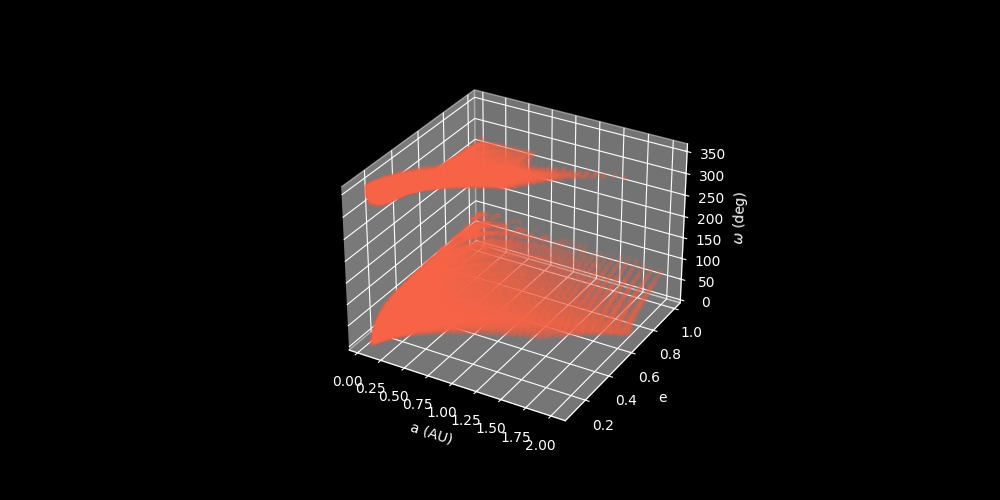

In [80]:
out_s_p = np.array(out_s).T
fig=plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1,projection='3d')
ax1.plot(out_s_p[0],out_s_p[1],out_s_p[2],'.',alpha=0.1,color='tomato')
ax1.set_xlabel('a (AU)')
ax1.set_ylabel('e')
ax1.set_zlabel('$\omega$ (deg)')